In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from scipy.stats import bernoulli, binom

# Part 1: Empirical Learning Rates for the Exponential Weights Algorithm

## Set Up and Algorithm Definition

In [199]:
class EWAlg:
    def __init__(self, epsilon, k, h):
        self.weights = np.ones(k)
        self.payoffs = np.zeros(k)
        self.h = h
        self.k = k
        self.epsilon = epsilon
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights

    def getAction(self):
        j = np.random.choice(self.k, 1, p = self.probs)
        return j.item()
    
    def update(self, payoffs):
        for j in range(len(payoffs)):
            curPayoff = payoffs[j]
            self.payoffs[j] = self.payoffs[j] + curPayoff
            newWeight = (1+self.epsilon)**(self.payoffs[j]/self.h)
            self.weights[j] = newWeight
        self.sumWeights = np.sum(self.weights)
        if(self.epsilon > 1):
            self.weights = self.weights/self.sumWeights
            self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        return


In [200]:
def MonteCarlo(numTrials, payoffGenerator, epsilon, k, h, n):
    avgFinalPayoff = 0
    avgRegretPerRound = [[] for i in range(numTrials)]
    for trial in range(numTrials):
        alg = EWAlg(epsilon, k, h)
        finalPayoff = 0
        actionPayoffs = np.zeros(k)
        generator = payoffGenerator(k)
        regretPerRound = np.zeros(n)
        for i in range(n):
            payoffs = generator.generate()
            j = alg.getAction()
            myPayoff = payoffs[j]
            actionPayoffs += payoffs
            alg.update(payoffs)
            finalPayoff += myPayoff
            OPT = max(actionPayoffs)
            regret = (OPT - finalPayoff).item() / (i+1)
            regretPerRound[i] = regret
        avgFinalPayoff += finalPayoff
        avgRegretPerRound[trial] = regretPerRound
    return avgFinalPayoff/numTrials, np.mean(avgRegretPerRound, axis=0)

## Adversarial Fair Payoffs

In each round i:

Draw a payoff x ~ U[0,1] (i.e., from the uniform distribution on interval [0,1])

Assign this payoff to the action j* that has the smallest total payoff so far, i.e., j* = argminj Vji-1 where Vji = Σir=1 vji. 
(All other actions get 0 payoff in round i.)

In [201]:
class AdversarialFair:
    def __init__(self, k):
        self.totalPayoffs = np.zeros(k)
        self.k = k
        
    def generate(self):
        adversarialPayoffs = np.zeros(self.k)
        x = np.random.rand(1)
        least = np.argmin(self.totalPayoffs)
        adversarialPayoffs[least] = x
        self.totalPayoffs = self.totalPayoffs + adversarialPayoffs
        return adversarialPayoffs

In [202]:
h = 1 # fixed
# hyperparameters
k = 10
n = 100
epsilons = [-0.99, -0.5, 0, 0.1, 0.1517, 0.2, 0.4, 0.7, 1, 2, 10, 1000] # to be studied
monteCarloBound = 1000

AFEpsilonPayoffs = []
AFEpsilonRegretPerRound = []
for epsilon in epsilons:
    finalPayoff, regretPerRound = MonteCarlo(monteCarloBound, AdversarialFair, epsilon, k, h, n)
    AFEpsilonPayoffs.append(finalPayoff)
    AFEpsilonRegretPerRound.append(regretPerRound)

AFEpsilonAvgRegrets = [i[99] for i in AFEpsilonRegretPerRound]
print(epsilons)
print(AFEpsilonPayoffs)
print(AFEpsilonAvgRegrets)

[-0.99, -0.5, 0, 0.1, 0.1517, 0.2, 0.4, 0.7, 1, 2, 10, 1000]
[12.572066468624602, 6.089115420080595, 4.952127590364313, 4.888985005026019, 4.662385648248368, 4.658095671678926, 4.491083295527148, 4.237502645046786, 3.988782430758382, 3.551178754492665, 2.1475778776821812, 0.3206374990307352]
[-0.07164880805723829, -0.0066178097291542375, 0.0044772387027638095, 0.005445673155832275, 0.007507744684371933, 0.007499525986132154, 0.0091217183309684, 0.011695349045173858, 0.014306945820161048, 0.01850769358056152, 0.03260957846953832, 0.05091754046141372]


### Graphs for Adversarial Fair Payoffs

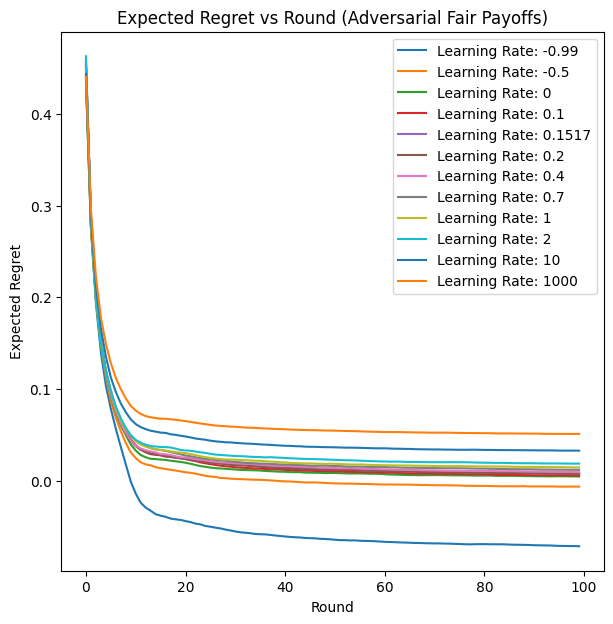

In [203]:
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(7)

for i in range(len(epsilons)):
    plt.plot(np.arange(n), AFEpsilonRegretPerRound[i], label = "Learning Rate: "+ str(epsilons[i]))
plt.title('Expected Regret vs Round (Adversarial Fair Payoffs)')
plt.xlabel('Round')
plt.ylabel('Expected Regret')
plt.legend()
plt.show()
f.savefig('RegretvRoundAf.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


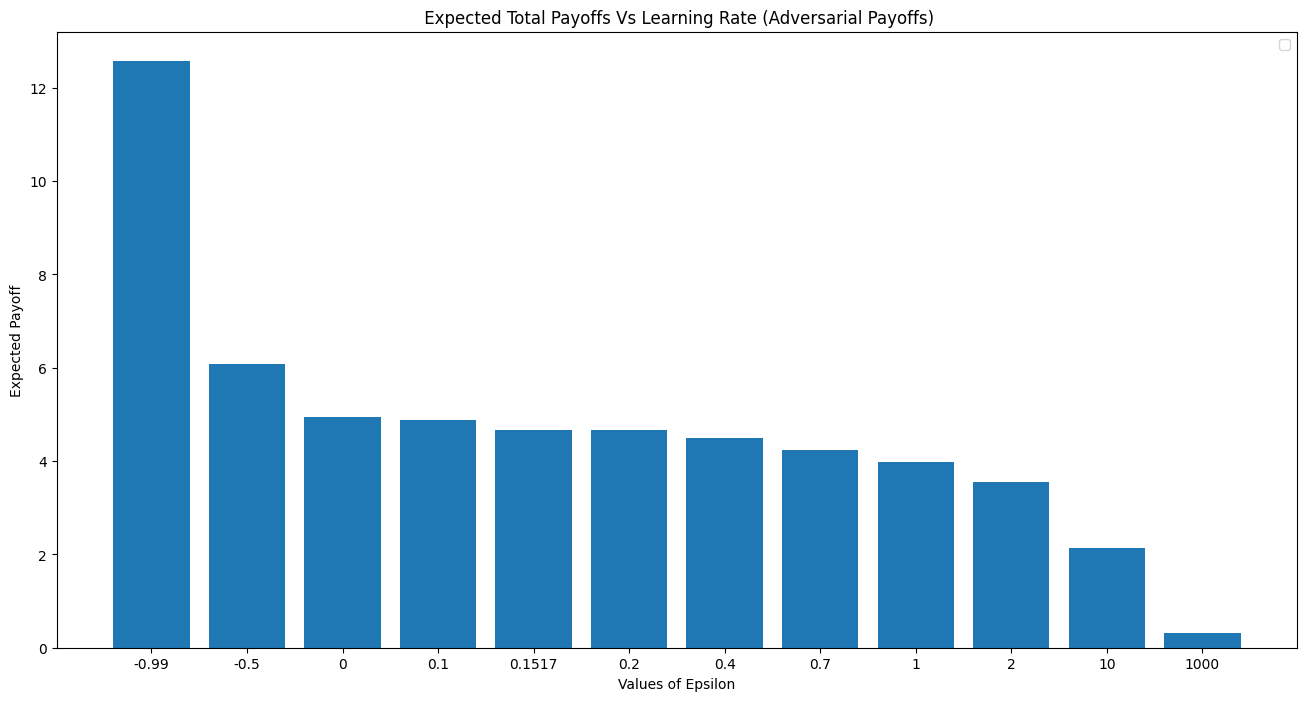

In [204]:
X_axis = np.arange(len(epsilons))
f, ax = plt.subplots(figsize=(16,8)) # set the size that you'd like (width, height)

plt.bar(X_axis, AFEpsilonPayoffs)

plt.xticks(X_axis, epsilons)
plt.xlabel("Values of Epsilon")
plt.ylabel("Expected Payoff")
plt.title(" Expected Total Payoffs Vs Learning Rate (Adversarial Payoffs)")
plt.legend()
plt.show()
f.savefig('PayoffAF.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


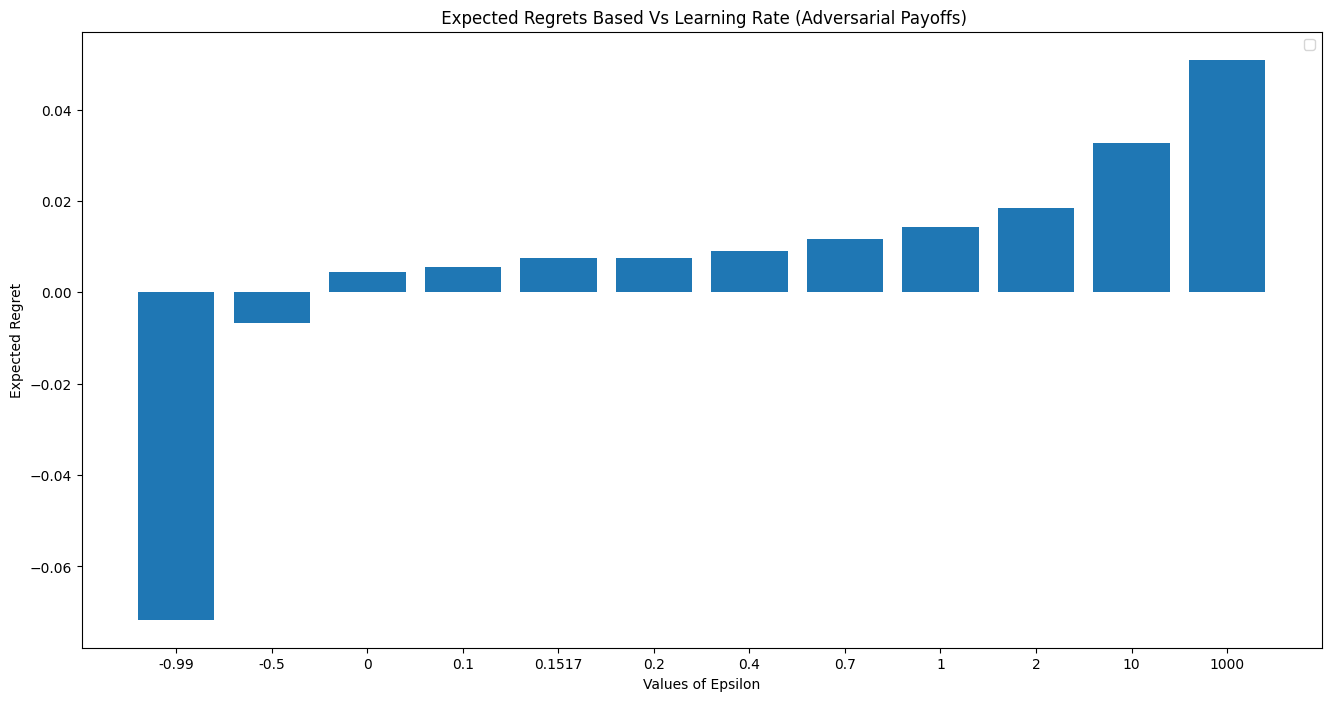

In [205]:
X_axis = np.arange(len(epsilons))
f, ax = plt.subplots(figsize=(16,8)) # set the size that you'd like (width, height)

plt.bar(X_axis, AFEpsilonAvgRegrets)
plt.xticks(X_axis, epsilons)
plt.xlabel("Values of Epsilon")
plt.ylabel("Expected Regret")
plt.title(" Expected Regrets Based Vs Learning Rate (Adversarial Payoffs)")
plt.legend()
plt.show()
f.savefig('RegretAF.png')


## Bernoulli Payoffs

Fix a probability for each action p1,...,pk with each pk in [0,1/2].

In each round i, draw the payoff of each action j as vji ~ B(pj) (i.e, from the Bernoulli distribution with probability pj of being 1 and probability 1-pj of being 0).

In [206]:
class Bernoulli:
    def __init__(self, k):
        self.k = k
        payoffProbs = np.random.uniform(0, 0.5, k)
        self.bernouliPayoffs = [bernoulli(p) for p in payoffProbs]
        
    def generate(self):
        payoffs = np.array([b.rvs(1) for b in self.bernouliPayoffs]).flatten()
        return payoffs

In [207]:
h = 1 # fixed
# hyperparameters
k = 10
n = 100
epsilons = [0, 0.1, 0.1517, 0.2, 0.4, 0.7, 1, 2, 10, 1000] # to be studied
monteCarloBound = 1000

bernoulliEpsilonPayoffs = []
bernoulliEpsilonRegretPerRound = []
for epsilon in epsilons:
    finalPayoff, regretPerRound = MonteCarlo(monteCarloBound, Bernoulli, epsilon, k, h, n)
    bernoulliEpsilonPayoffs.append(finalPayoff)
    bernoulliEpsilonRegretPerRound.append(regretPerRound)

bernoulliEpsilonAvgRegrets = [i[99] for i in bernoulliEpsilonRegretPerRound]
print(epsilons)
print(bernoulliEpsilonPayoffs)
print(bernoulliEpsilonAvgRegrets)

[0, 0.1, 0.1517, 0.2, 0.4, 0.7, 1, 2, 10, 1000]
[25.105, 32.6, 34.851, 36.418, 39.186, 40.47, 41.151, 41.54, 42.376, 42.296]
[0.2226700000000001, 0.14403999999999986, 0.1253700000000001, 0.10958, 0.08147999999999996, 0.06672000000000007, 0.06090000000000001, 0.05561999999999997, 0.04996000000000002, 0.050320000000000024]


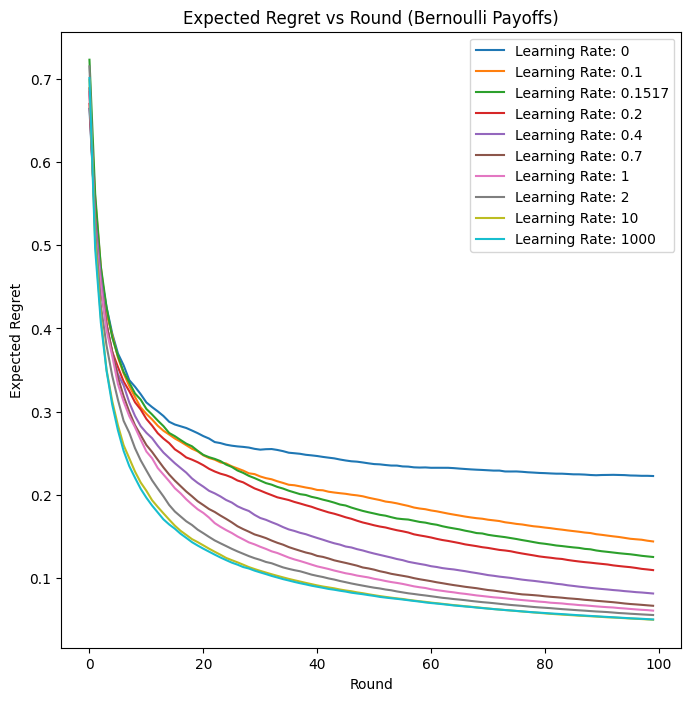

In [208]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)

for i in range(len(epsilons)):
    plt.plot(np.arange(n), bernoulliEpsilonRegretPerRound[i], label = "Learning Rate: "+str(epsilons[i]))
plt.title('Expected Regret vs Round (Bernoulli Payoffs)')
plt.xlabel('Round')
plt.ylabel('Expected Regret')
plt.legend()
plt.show()
f.savefig('RegretvRoundB.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


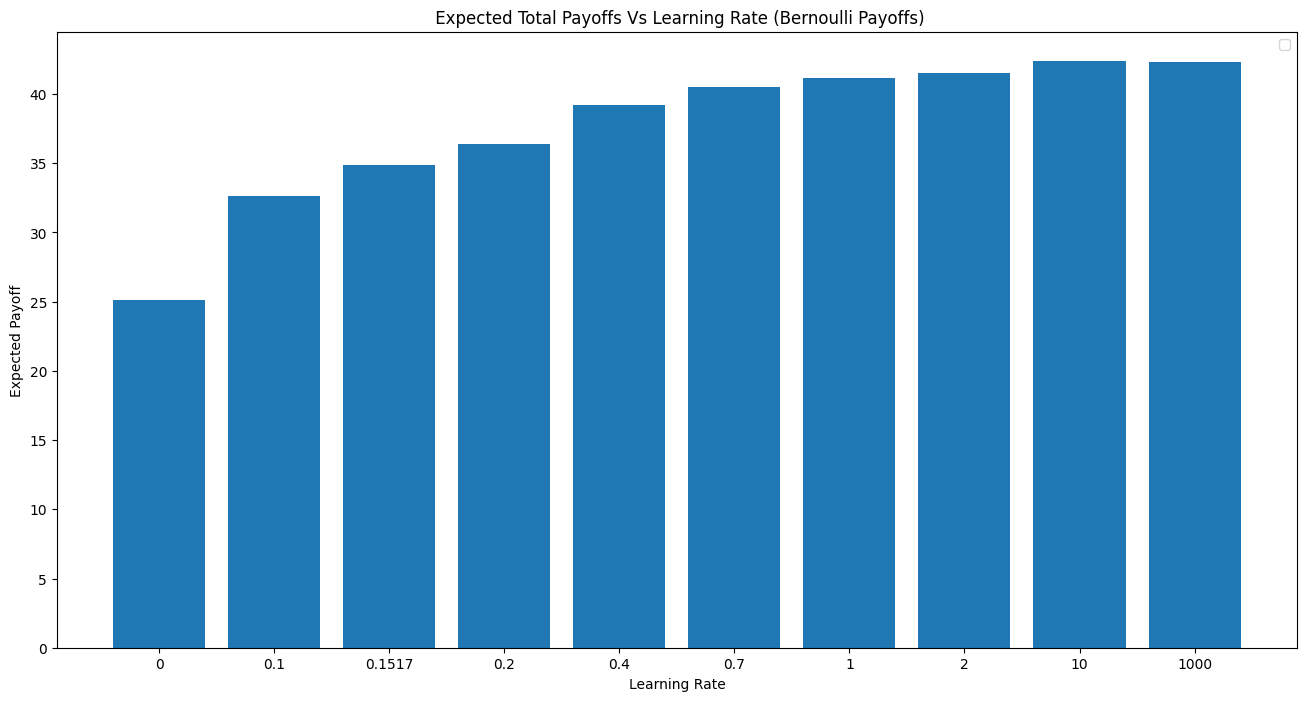

In [209]:
X_axis = np.arange(len(epsilons))
f, ax = plt.subplots(figsize=(16,8)) # set the size that you'd like (width, height)

plt.bar(X_axis, bernoulliEpsilonPayoffs)

plt.xticks(X_axis, epsilons)
plt.xlabel("Learning Rate")
plt.ylabel("Expected Payoff")
plt.title(" Expected Total Payoffs Vs Learning Rate (Bernoulli Payoffs)")
plt.legend()
plt.show()
f.savefig('PayoffB.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


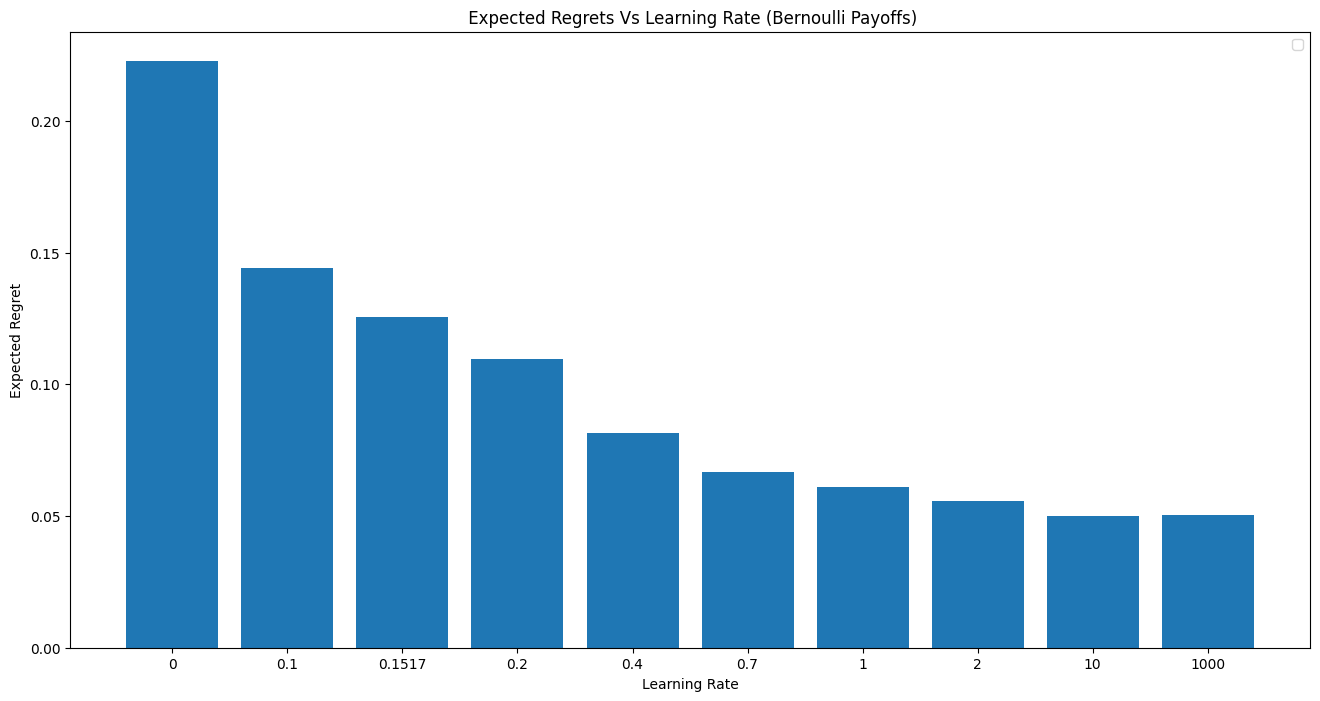

In [210]:
X_axis = np.arange(len(epsilons))
f, ax = plt.subplots(figsize=(16,8)) # set the size that you'd like (width, height)

plt.bar(X_axis, bernoulliEpsilonAvgRegrets)
plt.xticks(X_axis, epsilons)
plt.xlabel("Learning Rate")
plt.ylabel("Expected Regret")
plt.title(" Expected Regrets Vs Learning Rate (Bernoulli Payoffs)")
plt.legend()
plt.show()
f.savefig('RegretB.png')


# Part 2: Other Data Sources

## Data in the Wild : F1

In [211]:
# data source: http://ergast.com/mrd/
# f1Results = pd.read_csv("/Users/prabhavjain/Downloads/f1db_csv/constructor_results.csv")
# f1Races = pd.read_csv("/Users/prabhavjain/Downloads/f1db_csv/races.csv")
# f1Data = pd.merge(f1Results, f1Races, how="left", on="raceId")
# f1Data = f1Data[f1Data['year'] > 2018]
# f1Data = f1Data.drop(columns=['fp1_date', 'fp2_date', 'fp3_date', 'fp1_time', 'fp2_time', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time'])
# f1Data = f1Data.drop(columns=['constructorResultsId', 'raceId', 'url', 'time', 'name', 'circuitId', 'round', 'status', 'year'])
# constructorID = [9, 6, 210, 4, 131, 51, 211, 5, 1, 3, 213, 117, 214]
# constructorNames = ["Red Bull", "Ferrari", "Haas", "Alpine", "Mercedes", "Alfa Romeo", "Aston Martin", "Alpha Tauri", "Mclaren", "Williams", "Alpha Tauri", "Aston Martin", "Alpine"]
# f1Data['constructorId'] = f1Data['constructorId'].replace(constructorID, constructorNames)
# f1Data['points'] = f1Data['points'].astype('int')
# f1Data = f1Data.pivot(index='date', columns='constructorId', values='points')
# # f1Data.to_csv("/Users/prabhavjain/Northwestern Google Drive/CS 332/Online-Markets/f1Data.csv")

# to load data for future
# f1Data = pd.read_csv("/Users/prabhavjain/Northwestern Google Drive/CS 332/Online-Markets/f1Data.csv")

In [212]:
class F1Data:
    def __init__(self, k):
        self.k = k
        self.count = 0
        data = pd.read_csv("/Users/prabhavjain/Northwestern Google Drive/CS 332/Online-Markets/f1Data.csv")
        self.f1Data = np.array(data)[:, 1:].astype(int)

    def generate(self):
        payoffs = self.f1Data[self.count]
        self.count+=1
        return np.array(payoffs)

In [213]:
h = 58 # fixed
# hyperparameters
k = 10 # ten constructors
n = 82 # number of races
epsilons = [0, 0.1, 0.1675717936, 0.2, 0.4, 0.7, 1, 2, 10, 1000]
monteCarloBound = 1000

F1EpsilonPayoffs = []
F1EpsilonRegretPerRound = []
for epsilon in epsilons:
    finalPayoff, regretPerRound = MonteCarlo(monteCarloBound, F1Data, epsilon, k, h, n)
    F1EpsilonPayoffs.append(finalPayoff)
    F1EpsilonRegretPerRound.append(regretPerRound)

F1EpsilonAvgRegrets = [i[n-1] for i in F1EpsilonRegretPerRound]
print(epsilons)
print(F1EpsilonPayoffs)
print(F1EpsilonAvgRegrets)

[0, 0.1, 0.1675717936, 0.2, 0.4, 0.7, 1, 2, 10, 1000]
[842.088, 1447.985, 1707.613, 1792.152, 2041.145, 2175.388, 2230.08, 2297.381, 2366.486, 2401.322]
[19.486731707317045, 12.097743902438998, 8.931548780487804, 7.900585365853657, 4.864085365853661, 3.2269756097560975, 2.560000000000002, 1.7392560975609743, 0.8965121951219521, 0.47168292682926927]


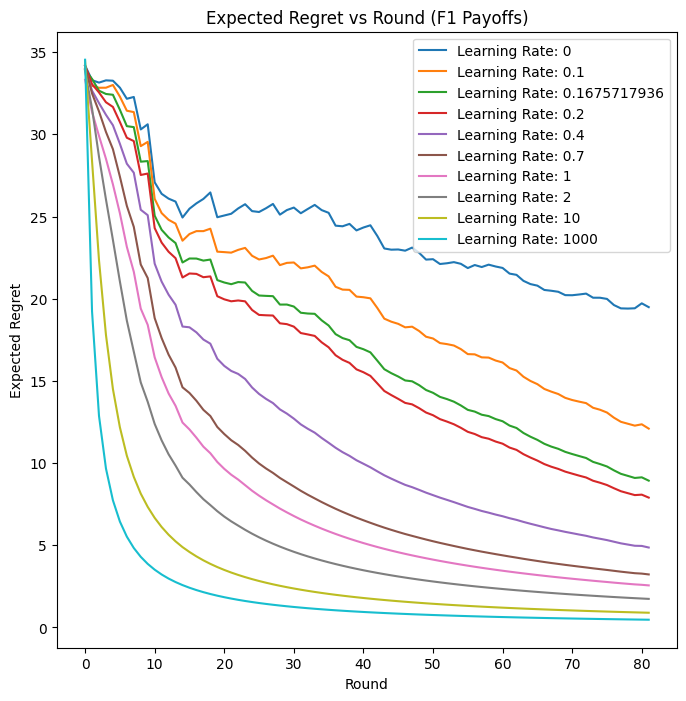

In [214]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)

for i in range(len(epsilons)):
    plt.plot(np.arange(n), F1EpsilonRegretPerRound[i], label = "Learning Rate: "+str(epsilons[i]))
plt.title('Expected Regret vs Round (F1 Payoffs)')
plt.xlabel('Round')
plt.ylabel('Expected Regret')
plt.legend()
plt.show()
f.savefig('RegretvRoundF1.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


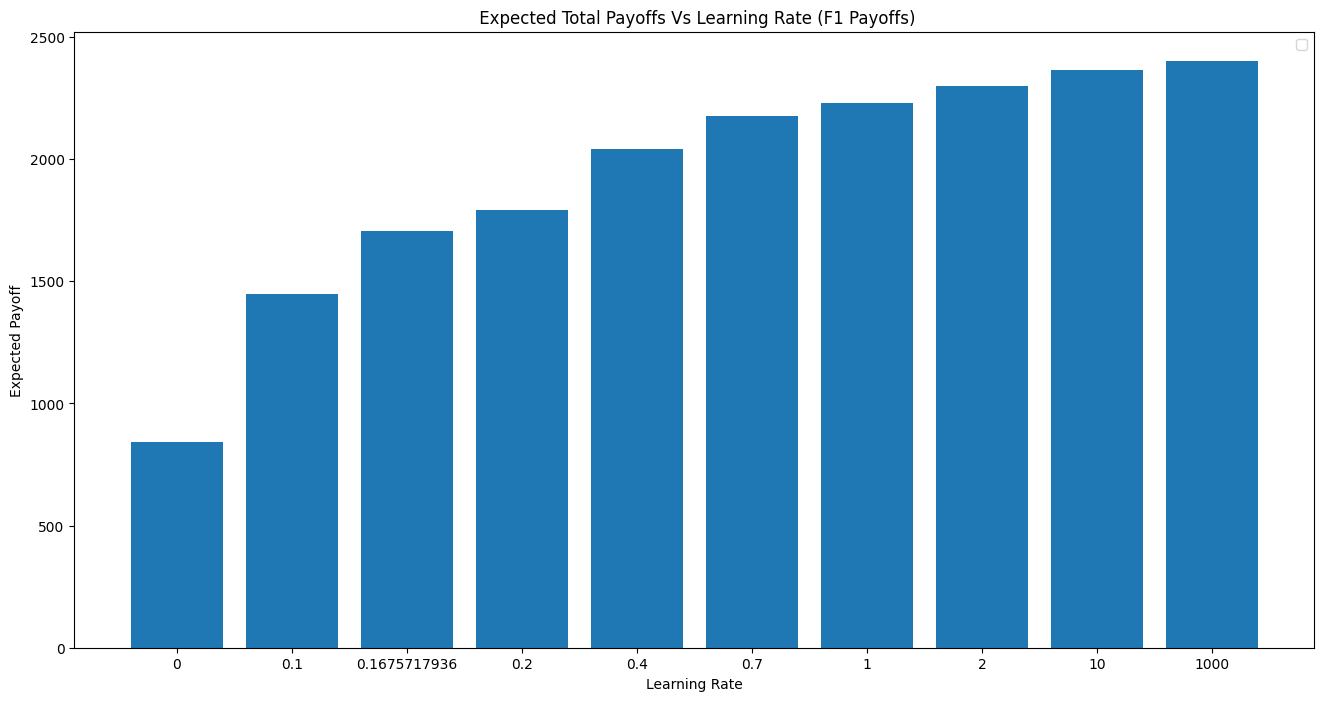

In [215]:
X_axis = np.arange(len(epsilons))
f, ax = plt.subplots(figsize=(16,8)) # set the size that you'd like (width, height)

plt.bar(X_axis, F1EpsilonPayoffs)

plt.xticks(X_axis, epsilons)
plt.xlabel("Learning Rate")
plt.ylabel("Expected Payoff")
plt.title(" Expected Total Payoffs Vs Learning Rate (F1 Payoffs)")
plt.legend()
plt.show()
f.savefig('PayoffF1.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


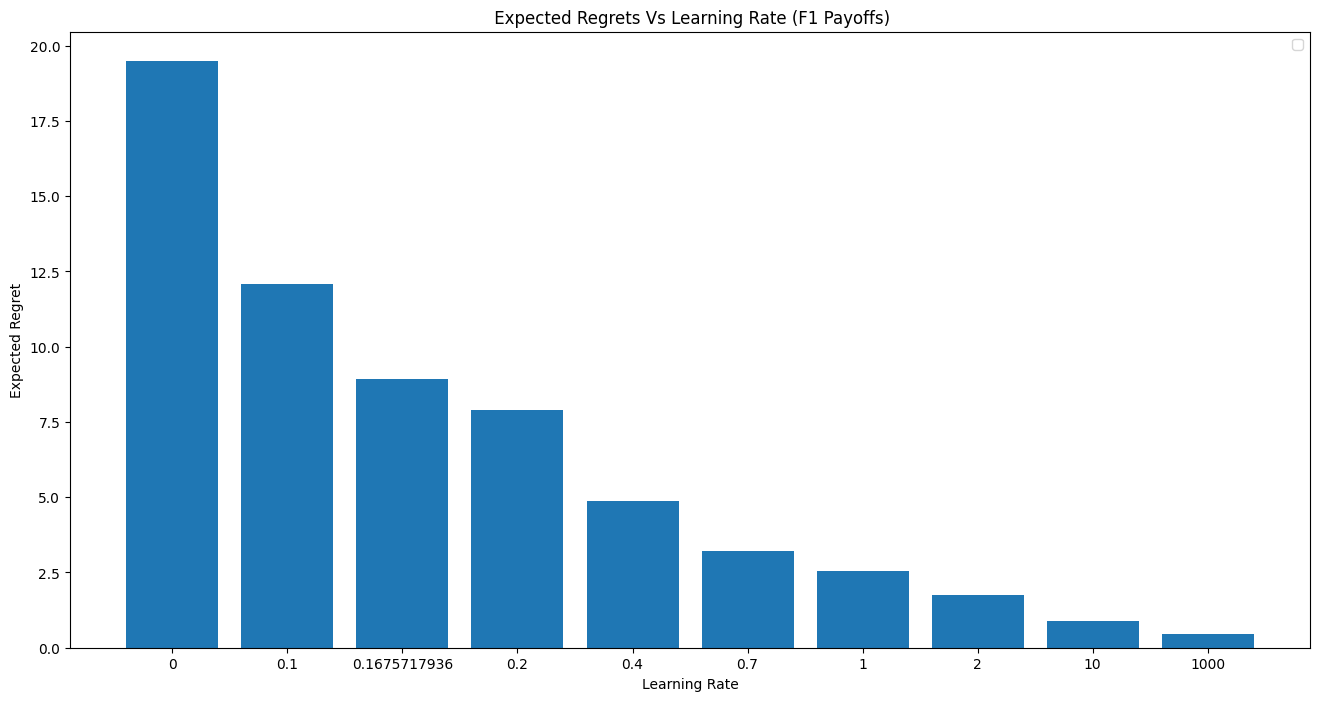

In [216]:
X_axis = np.arange(len(epsilons))
f, ax = plt.subplots(figsize=(16,8)) # set the size that you'd like (width, height)

plt.bar(X_axis, F1EpsilonAvgRegrets)
plt.xticks(X_axis, epsilons)
plt.xlabel("Learning Rate")
plt.ylabel("Expected Regret")
plt.title(" Expected Regrets Vs Learning Rate (F1 Payoffs)")
plt.legend()
plt.show()
f.savefig('RegretF1.png')


## Adversarial Generative Model

In [217]:
class Adversarial:
    def __init__(self, k):
        self.k = k
        self.totalPayoffs = np.zeros(k)

    def generate(self):
        adversarialPayoffs = np.zeros(k)
        x = np.random.rand(1)
        if (self.totalPayoffs[0] > self.totalPayoffs[1]): adversarialPayoffs[1] += x
        else : adversarialPayoffs[0] += x
        self.totalPayoffs += adversarialPayoffs
        return adversarialPayoffs

In [218]:
h = 1 # fixed
# hyperparameters
k = 10
n = 300
epsilons = [0, 0.1, 0.0876, 0.2, 0.4, 0.7, 1, 2, 10, 1000] # to be studied
monteCarloBound = 1000

adversarialEpsilonPayoffs = []
adversarialEpsilonRegretPerRound = []
for epsilon in epsilons:
    finalPayoff, regretPerRound = MonteCarlo(monteCarloBound, Adversarial, epsilon, k, h, n)
    adversarialEpsilonPayoffs.append(finalPayoff)
    adversarialEpsilonRegretPerRound.append(regretPerRound)

adversarialEpsilonAvgRegrets = [i[n-1] for i in adversarialEpsilonRegretPerRound]
print(epsilons)
print(adversarialEpsilonPayoffs)
print(adversarialEpsilonAvgRegrets)

[0, 0.1, 0.0876, 0.2, 0.4, 0.7, 1, 2, 10, 1000]
[14.959484188908116, 57.17281171883131, 55.07659402080763, 64.08820153723154, 65.98179949347089, 65.54552939456336, 64.36990962698428, 59.90626073578286, 48.01775586695627, 24.76669185045498]
[0.20051806716276827, 0.06013940256824995, 0.06707871680593734, 0.03684337822910576, 0.030308583577400693, 0.03203532165614659, 0.035677458814488694, 0.05008901483235555, 0.09044955741936023, 0.16815921756349517]


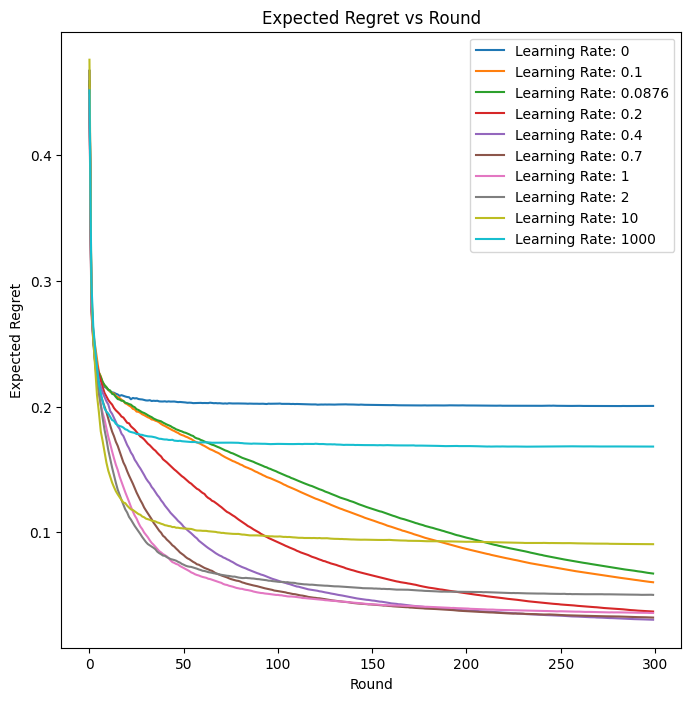

In [219]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)

for i in range(len(epsilons)):
    plt.plot(np.arange(n), adversarialEpsilonRegretPerRound[i], label = "Learning Rate: "+str(epsilons[i]))
plt.title('Expected Regret vs Round')
plt.xlabel('Round')
plt.ylabel('Expected Regret')
plt.legend()
plt.show()
f.savefig('RegretvRoundA.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


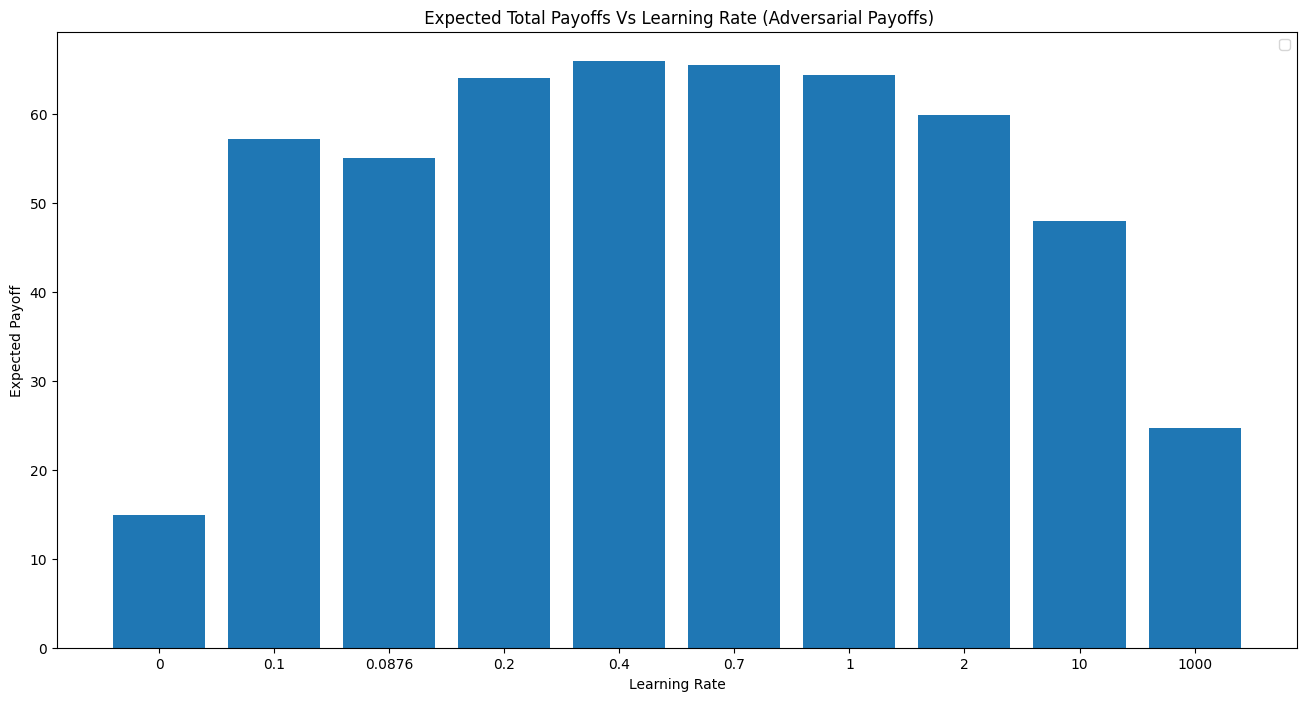

In [220]:
X_axis = np.arange(len(epsilons))
f, ax = plt.subplots(figsize=(16,8)) # set the size that you'd like (width, height)

plt.bar(X_axis, adversarialEpsilonPayoffs)

plt.xticks(X_axis, epsilons)
plt.xlabel("Learning Rate")
plt.ylabel("Expected Payoff")
plt.title(" Expected Total Payoffs Vs Learning Rate (Adversarial Payoffs)")
plt.legend()
plt.show()
f.savefig('PayoffA.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


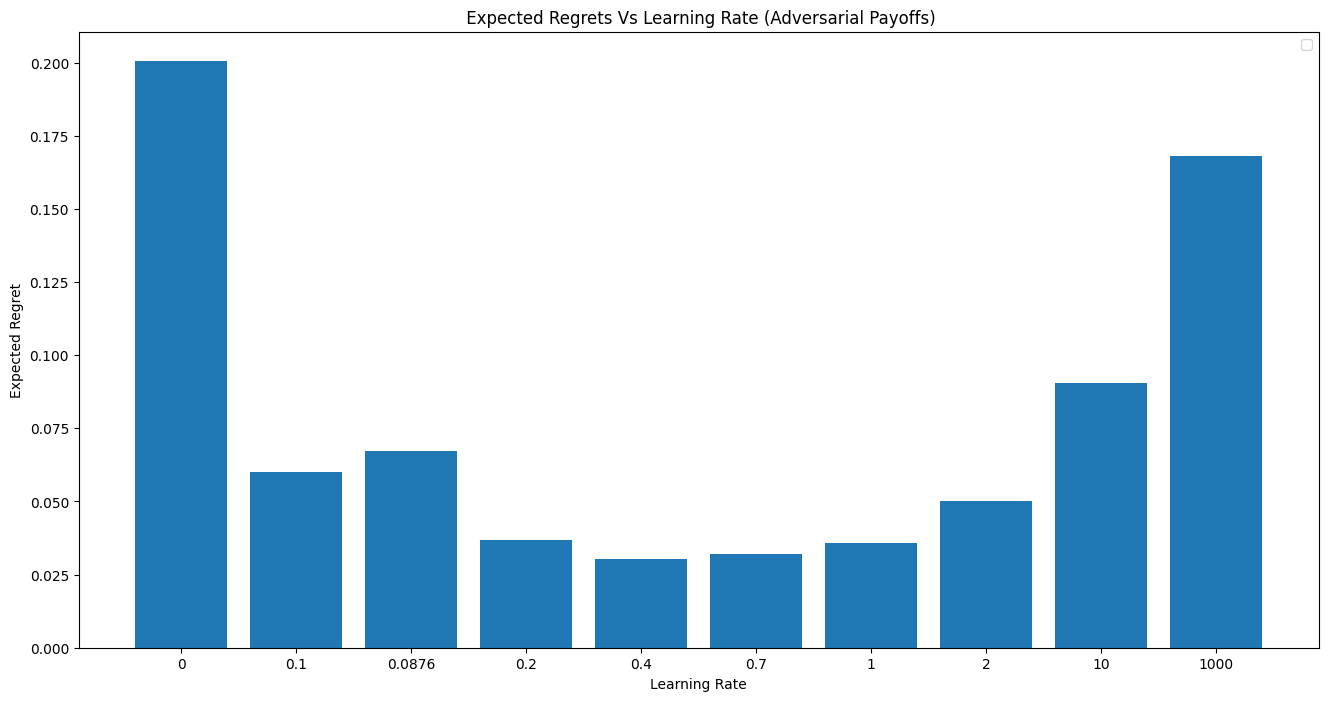

In [221]:
X_axis = np.arange(len(epsilons))
f, ax = plt.subplots(figsize=(16,8)) # set the size that you'd like (width, height)

plt.bar(X_axis, adversarialEpsilonAvgRegrets)
plt.xticks(X_axis, epsilons)
plt.xlabel("Learning Rate")
plt.ylabel("Expected Regret")
plt.title(" Expected Regrets Vs Learning Rate (Adversarial Payoffs)")
plt.legend()
plt.show()
f.savefig('RegretA.png')
